# 1) Installing libraries

In [1]:
#Installation of required libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import random

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
import joblib

#To remove warnings
import warnings
warnings.simplefilter(action = "ignore") 

<h1>2) Importing Data</h1>

In [2]:
diabetes_df = pd.read_csv('diabetes_data.csv')

In [3]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


<h2>2.1) Exploratory data analysis </h2>

In [4]:
diabetes_df.shape

(768, 9)

In [5]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               766 non-null    float64
 1   Glucose                   766 non-null    float64
 2   BloodPressure             765 non-null    float64
 3   SkinThickness             764 non-null    float64
 4   Insulin                   764 non-null    float64
 5   BMI                       763 non-null    float64
 6   DiabetesPedigreeFunction  766 non-null    float64
 7   Age                       761 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


In [6]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,766.000000,766.000000,765.000000,764.000000,764.000000,763.000000,766.000000,761.000000,768.000000
mean,3.844648,120.738903,69.107190,20.501309,79.598168,31.996986,0.472295,33.206307,0.348958
std,3.370482,31.861132,19.390963,15.938816,115.262215,7.896483,0.331456,11.772661,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,27.000000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,126.250000,36.600000,0.626750,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 3) Missing Value Analysis

In [7]:
diabetes_df.isnull().sum()

Pregnancies                 2
Glucose                     2
BloodPressure               3
SkinThickness               4
Insulin                     4
BMI                         5
DiabetesPedigreeFunction    2
Age                         7
Outcome                     0
dtype: int64

<h2>There are some features that contain 0 and because this does not make sense for the data, the values of 0 are replaced by NaN</h2>

In [8]:
diabetes_df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes_df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [9]:
diabetes_df.isnull().sum()

Pregnancies                   2
Glucose                       7
BloodPressure                38
SkinThickness               230
Insulin                     377
BMI                          16
DiabetesPedigreeFunction      2
Age                           7
Outcome                       0
dtype: int64

In [10]:
diabetes_df.isnull()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,False,False,False,False,True,False,False,False,False
1,False,False,False,False,True,False,False,False,False
2,False,False,False,True,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
763,False,False,False,False,False,False,False,False,False
764,False,False,False,False,True,False,False,False,False
765,False,False,False,False,False,False,False,False,False
766,False,False,False,True,True,False,False,False,False


In [11]:
diabetes_df.isna().any().sum()

8

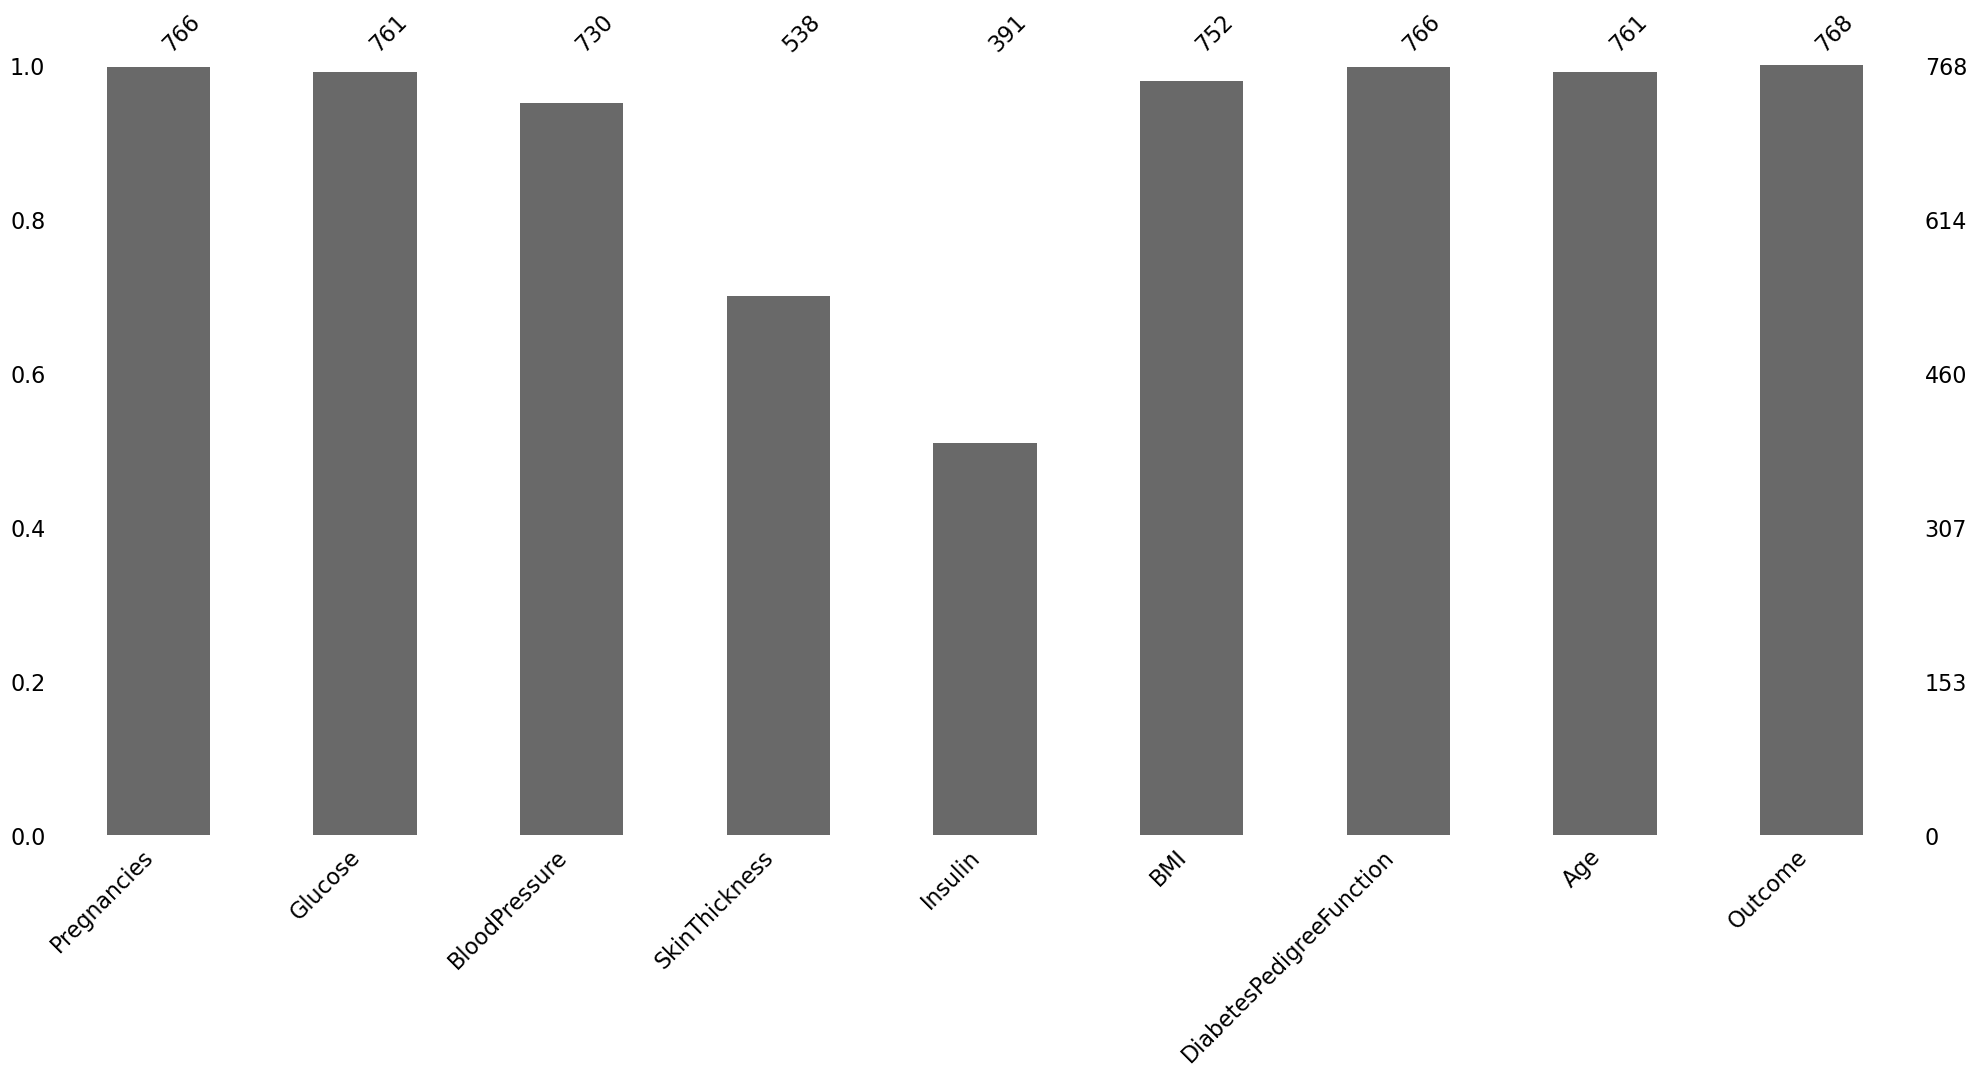

In [12]:
import missingno as msno
msno.bar(diabetes_df);

<h1> 4) Data Pre-processing </h1>

## 4.1) Removing missing vlaues

In [13]:
def median_target(var):   
    temp = diabetes_df[diabetes_df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [14]:
columns = diabetes_df.columns
columns = columns.drop("Outcome")
for i in columns:
    median_target(i)
    diabetes_df.loc[(diabetes_df['Outcome'] == 0 ) & (diabetes_df[i].isnull()), i] = median_target(i)[i][0]
    diabetes_df.loc[(diabetes_df['Outcome'] == 1 ) & (diabetes_df[i].isnull()), i] = median_target(i)[i][1]
    

In [15]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,100.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


In [16]:
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

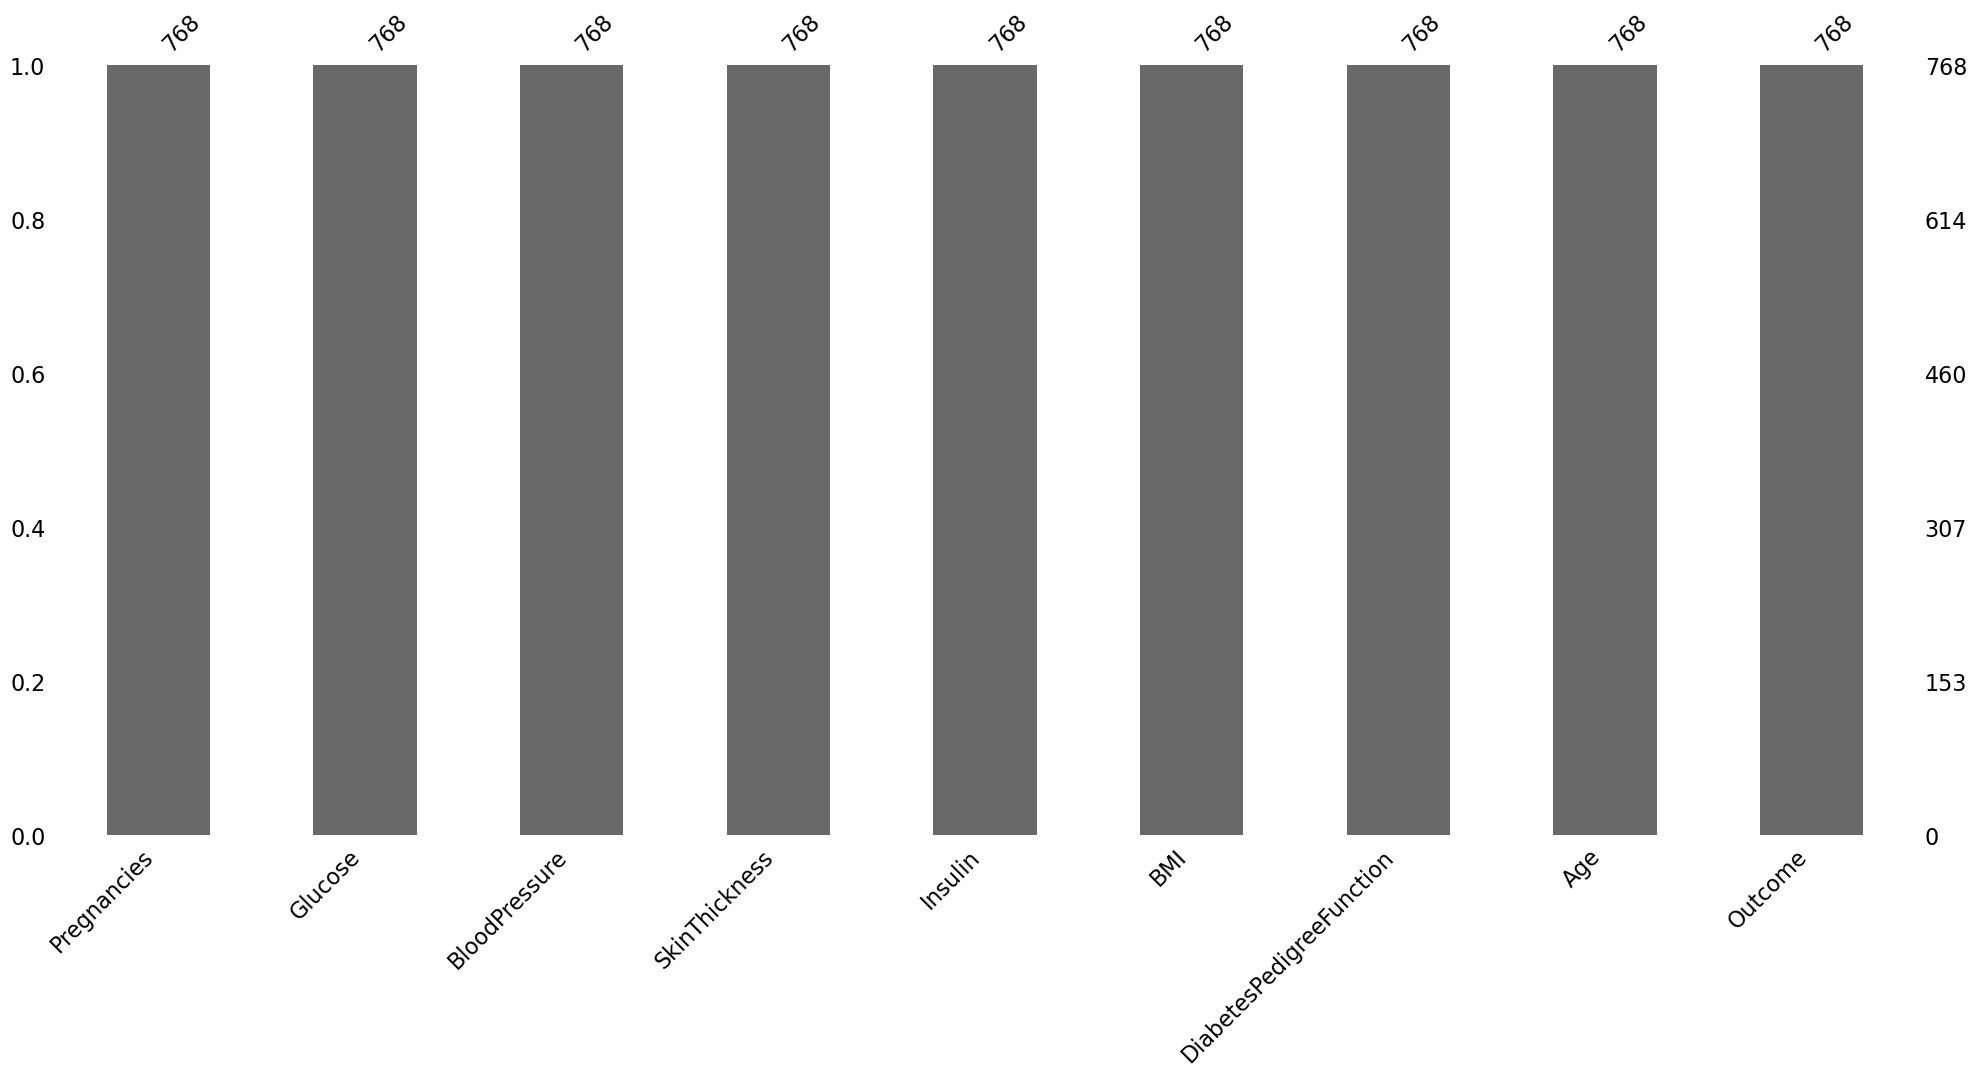

In [17]:
import missingno as msno
msno.bar(diabetes_df);

## 4.2) Data Visualization

0    500
1    268
Name: Outcome, dtype: int64


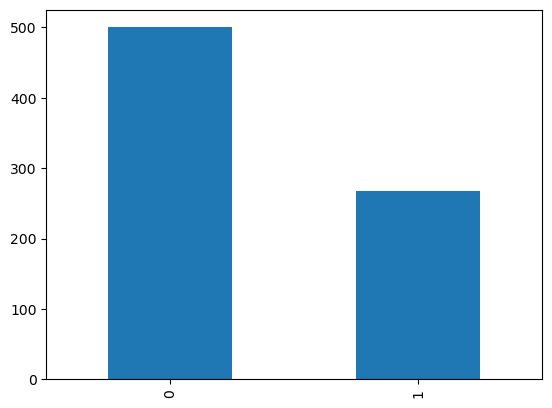

In [18]:
color_wheel = {1: "#0392cf", 2: "#7bc043"}
colors = diabetes_df["Outcome"].map(lambda x: color_wheel.get(x + 1))
print(diabetes_df.Outcome.value_counts())
p=diabetes_df.Outcome.value_counts().plot(kind="bar")

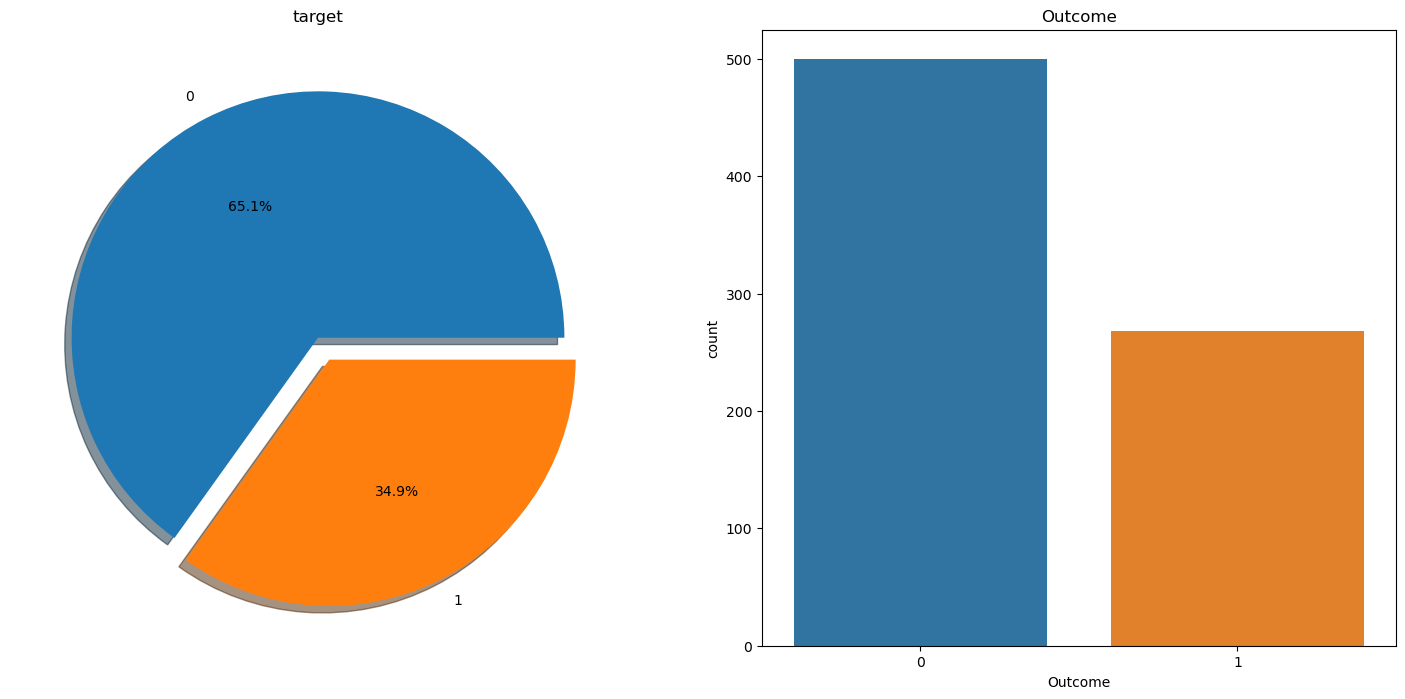

In [19]:
f,ax=plt.subplots(1,2,figsize=(18,8))
diabetes_df['Outcome'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('target')
ax[0].set_ylabel('')
sns.countplot('Outcome',data=diabetes_df,ax=ax[1])
ax[1].set_title('Outcome')
plt.show()

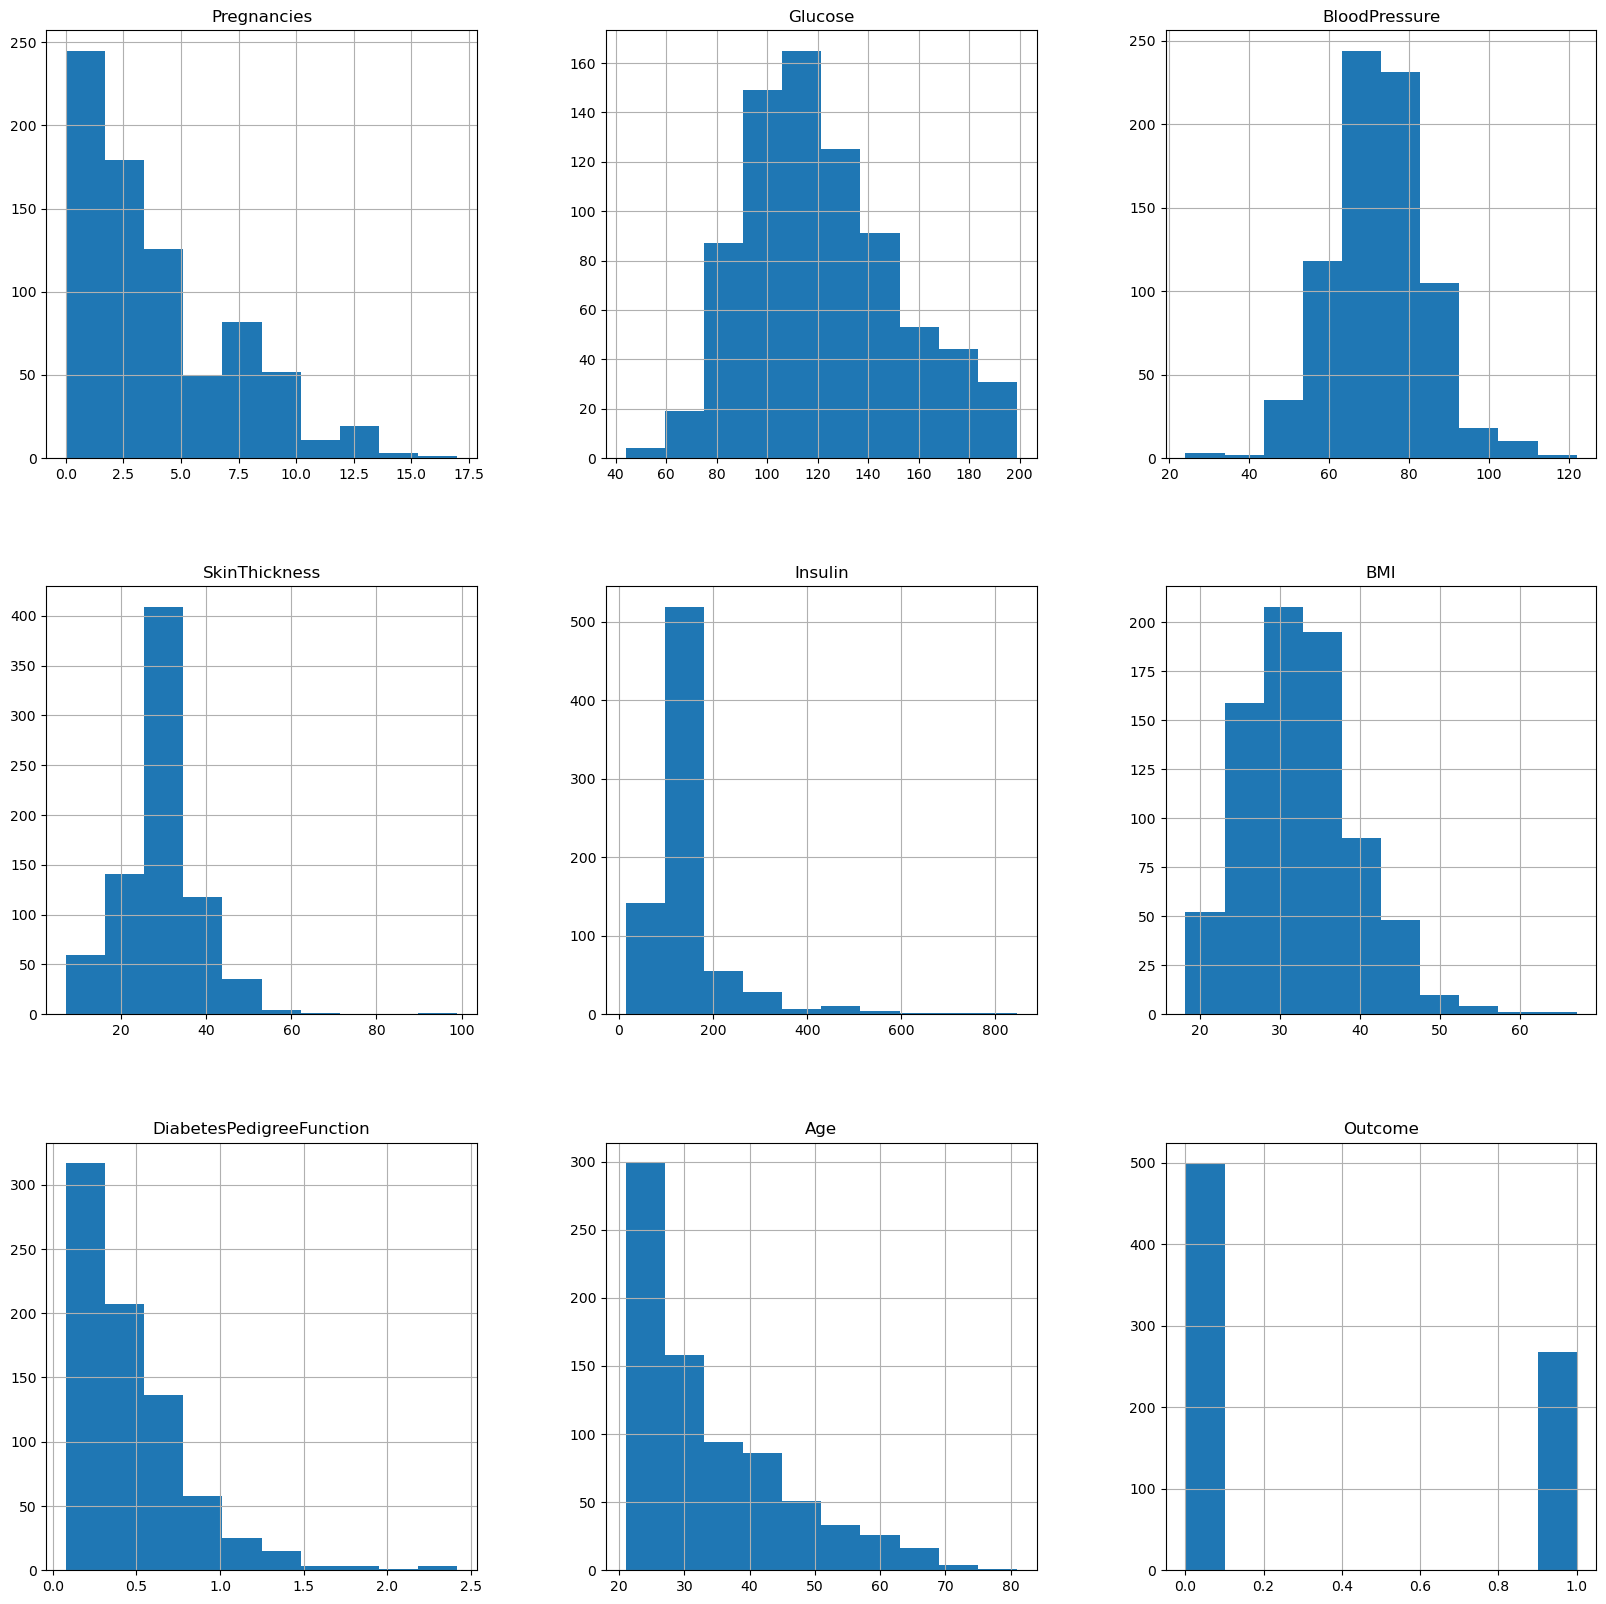

In [20]:
p = diabetes_df.hist(figsize = (20,20))

<AxesSubplot:xlabel='BMI', ylabel='Density'>

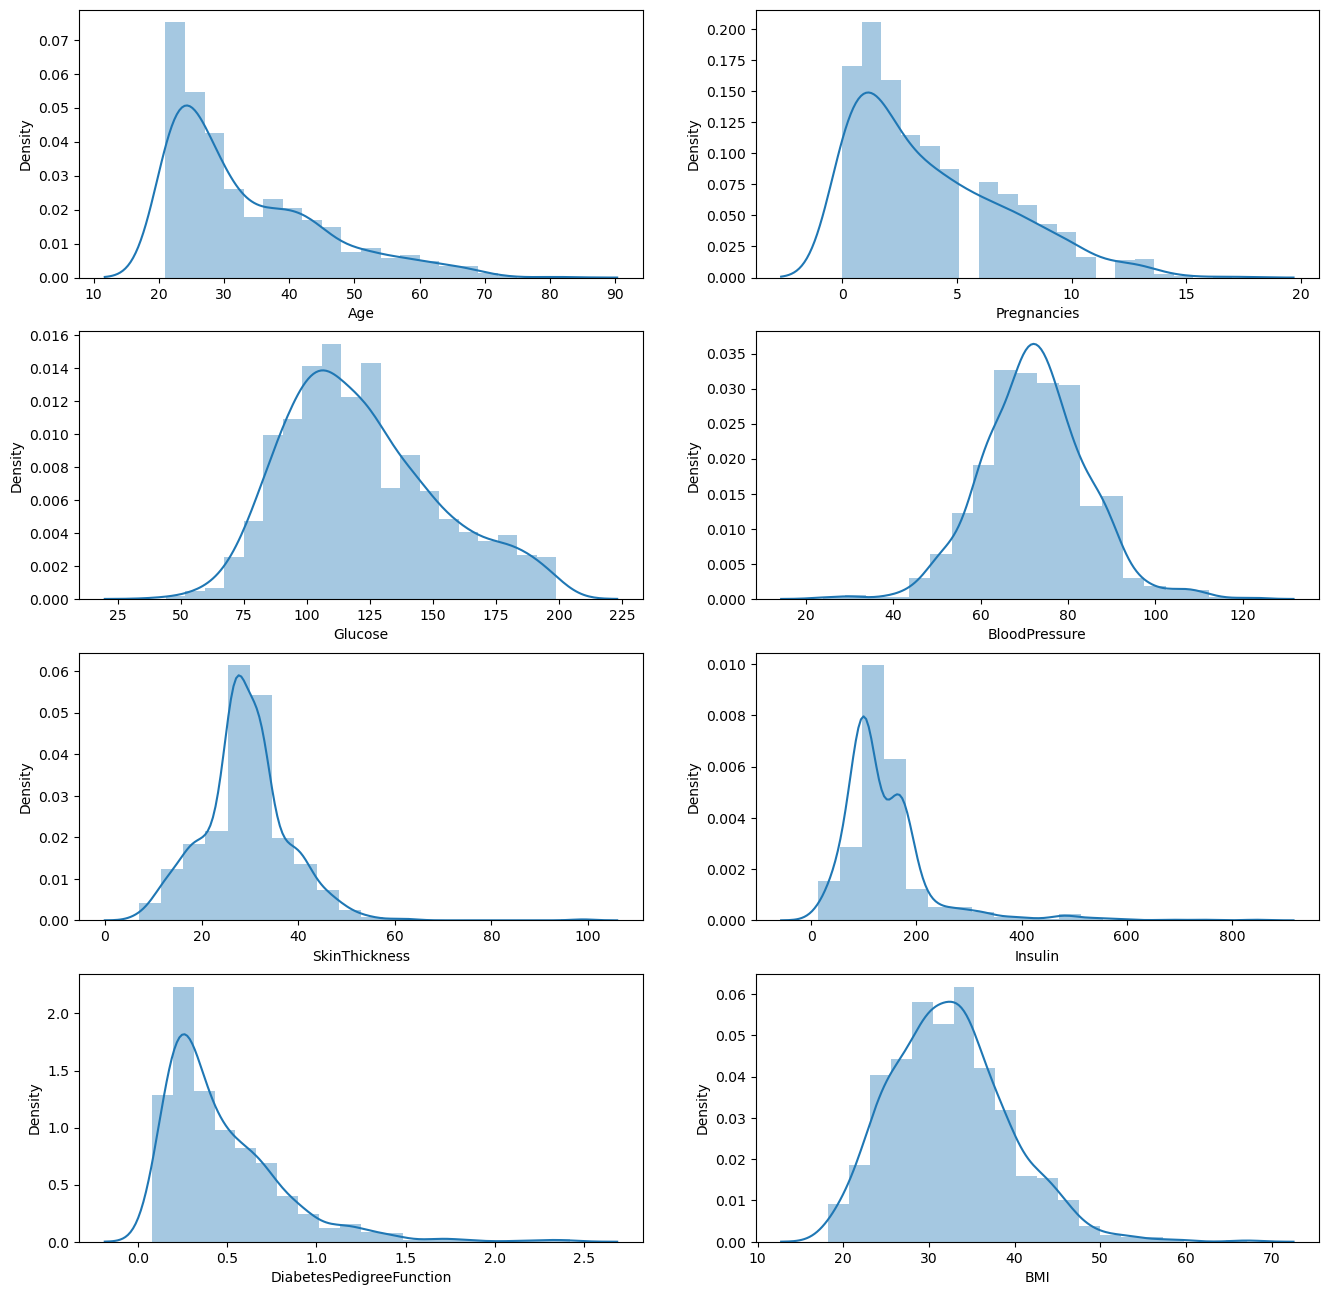

In [21]:
fig, ax = plt.subplots(4,2, figsize=(16,16))
sns.distplot(diabetes_df.Age, bins = 20, ax=ax[0,0]) 
sns.distplot(diabetes_df.Pregnancies, bins = 20, ax=ax[0,1]) 
sns.distplot(diabetes_df.Glucose, bins = 20, ax=ax[1,0]) 
sns.distplot(diabetes_df.BloodPressure, bins = 20, ax=ax[1,1]) 
sns.distplot(diabetes_df.SkinThickness, bins = 20, ax=ax[2,0])
sns.distplot(diabetes_df.Insulin, bins = 20, ax=ax[2,1])
sns.distplot(diabetes_df.DiabetesPedigreeFunction, bins = 20, ax=ax[3,0]) 
sns.distplot(diabetes_df.BMI, bins = 20, ax=ax[3,1]) 

<AxesSubplot:>

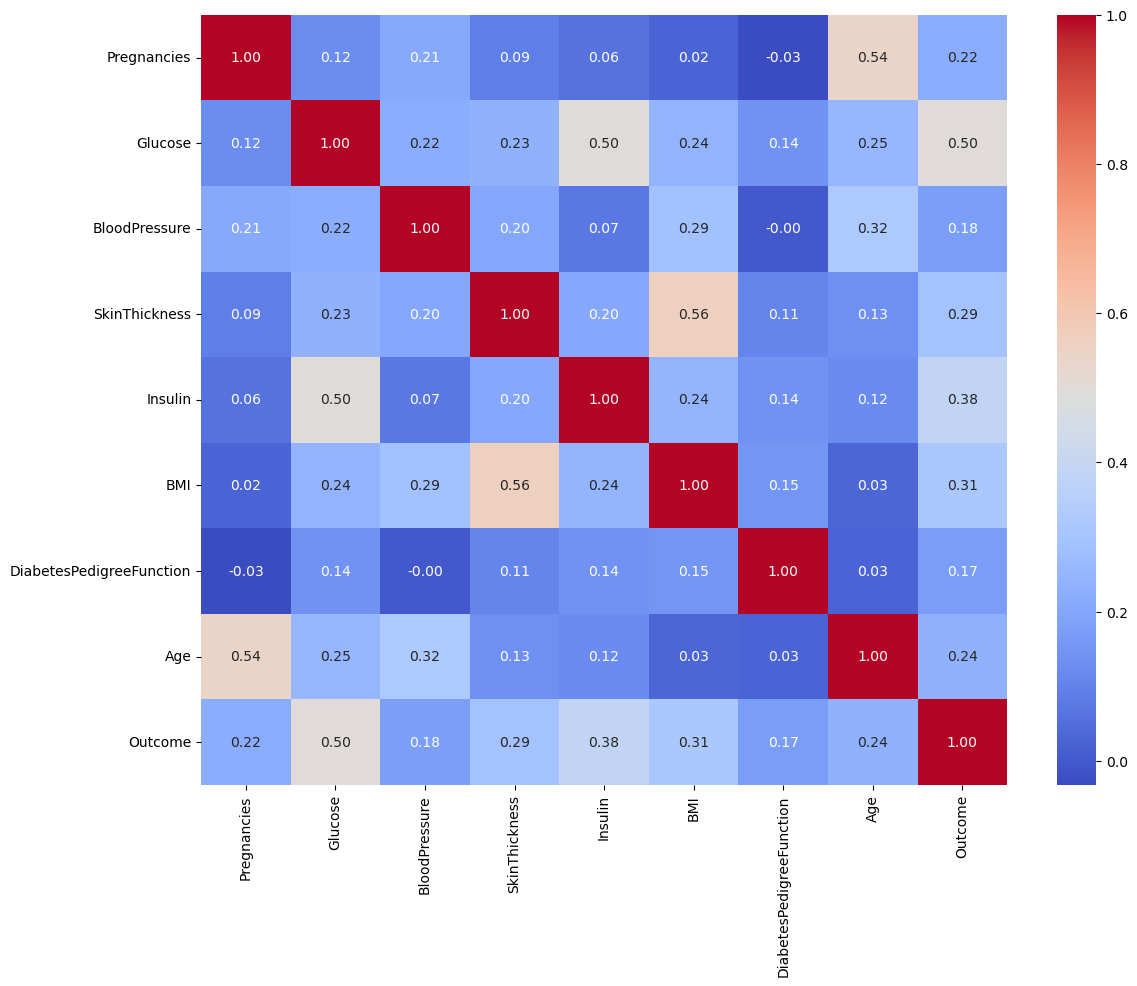

In [22]:
plt.figure(figsize=(13,10))
sns.heatmap(diabetes_df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

<h2> 4.3) Outlier Observation </h2>

In [23]:
for feature in diabetes_df:
    
    Q1 = diabetes_df[feature].quantile(0.25)
    Q3 = diabetes_df[feature].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1- 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if diabetes_df[(diabetes_df[feature] > upper)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

Pregnancies yes
Glucose no
BloodPressure yes
SkinThickness yes
Insulin yes
BMI yes
DiabetesPedigreeFunction yes
Age yes
Outcome no


## 4.4)  Local Outlier Factor (LOF)

In [24]:
from sklearn.neighbors import LocalOutlierFactor
lof =LocalOutlierFactor(n_neighbors= 10)
lof.fit_predict(diabetes_df)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1

In [25]:
diabetes_df_scores = lof.negative_outlier_factor_
np.sort(diabetes_df_scores)[0:30]

array([-3.30659871, -3.05291138, -2.49046751, -2.38674238, -2.17580569,
       -2.09457056, -2.02394396, -2.01228878, -1.95465482, -1.83423162,
       -1.78983278, -1.76517558, -1.71708031, -1.68594463, -1.67716274,
       -1.66483397, -1.63931849, -1.63785316, -1.6283776 , -1.61557486,
       -1.60293558, -1.59681624, -1.59558835, -1.58906907, -1.58717481,
       -1.56023733, -1.51234704, -1.51149198, -1.50469154, -1.50046152])

In [26]:
threshold = np.sort(diabetes_df_scores)[7]
threshold

-2.0122887800588827

In [27]:
outlier = diabetes_df_scores > threshold
diabetes_df = diabetes_df[outlier]

In [28]:
diabetes_df.shape

(760, 9)

## 4.5) Feature Engineering

Creating new variables is important for models.For this data set, some new variables were created according to BMI, Insulin and glucose variables.

In [29]:
NewBMI = pd.Series(["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")
diabetes_df["NewBMI"] = NewBMI
diabetes_df.loc[diabetes_df["BMI"] < 18.5, "NewBMI"] = NewBMI[0]
diabetes_df.loc[(diabetes_df["BMI"] > 18.5) & (diabetes_df["BMI"] <= 24.9), "NewBMI"] = NewBMI[1]
diabetes_df.loc[(diabetes_df["BMI"] > 24.9) & (diabetes_df["BMI"] <= 29.9), "NewBMI"] = NewBMI[2]
diabetes_df.loc[(diabetes_df["BMI"] > 29.9) & (diabetes_df["BMI"] <= 34.9), "NewBMI"] = NewBMI[3]
diabetes_df.loc[(diabetes_df["BMI"] > 34.9) & (diabetes_df["BMI"] <= 39.9), "NewBMI"] = NewBMI[4]
diabetes_df.loc[diabetes_df["BMI"] > 39.9 ,"NewBMI"] = NewBMI[5]

In [30]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,Obesity 1
1,1.0,85.0,66.0,29.0,100.0,26.6,0.351,31.0,0,Overweight
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,Normal
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,Overweight
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1,Obesity 3


In [31]:
def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal"

In [32]:
# The operation performed was added to the dataframe.
diabetes_df = diabetes_df.assign(NewInsulinScore=diabetes_df.apply(set_insulin, axis=1))

diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,Obesity 1,Abnormal
1,1.0,85.0,66.0,29.0,100.0,26.6,0.351,31.0,0,Overweight,Normal
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,Normal,Abnormal
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,Overweight,Normal
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1,Obesity 3,Abnormal


In [33]:
# Some intervals were determined according to the glucose variable and these were assigned categorical variables.
NewGlucose = pd.Series(["Low", "Normal", "Overweight", "Secret", "High"], dtype = "category")
diabetes_df["NewGlucose"] = NewGlucose
diabetes_df.loc[diabetes_df["Glucose"] <= 70, "NewGlucose"] = NewGlucose[0]
diabetes_df.loc[(diabetes_df["Glucose"] > 70) & (diabetes_df["Glucose"] <= 99), "NewGlucose"] = NewGlucose[1]
diabetes_df.loc[(diabetes_df["Glucose"] > 99) & (diabetes_df["Glucose"] <= 126), "NewGlucose"] = NewGlucose[2]
diabetes_df.loc[diabetes_df["Glucose"] > 126 ,"NewGlucose"] = NewGlucose[3]

In [34]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore,NewGlucose
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,Obesity 1,Abnormal,Secret
1,1.0,85.0,66.0,29.0,100.0,26.6,0.351,31.0,0,Overweight,Normal,Normal
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,Normal,Abnormal,Secret
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,Overweight,Normal,Normal
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1,Obesity 3,Abnormal,Secret


# 4.6) One Hot Encoding

In [35]:
diabetes_df = pd.get_dummies(diabetes_df, columns =["NewBMI","NewInsulinScore", "NewGlucose"], drop_first = True)

In [36]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,1,0,0,0,0,0,0,0,0,1
1,1.0,85.0,66.0,29.0,100.0,26.6,0.351,31.0,0,0,0,0,1,0,1,0,1,0,0
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,0,0,0,0,0,0,0,0,0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,0,0,0,1,0,1,0,1,0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1,0,0,1,0,0,0,0,0,0,1


In [37]:
catego = diabetes_df[['NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret']]

In [38]:
catego.head()

,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,1,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,1,0,1,0,0
4,0,0,1,0,0,0,0,0,0,1


In [39]:
y = diabetes_df["Outcome"]
X = diabetes_df.drop(["Outcome",'NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret'], axis = 1)
cols = X.columns
index = X.index

In [40]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,100.0,26.6,0.351,31.0
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0


In [41]:
# The variables in the data set are an effective factor in increasing the performance of the models by standardization.  
# There are multiple standardization methods. These are methods such as" Normalize"," MinMax"," Robust" and "Scale".
#data transforming
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)

In [42]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.6,0.770186,0.000,1.000000,1.000000,0.179775,0.674510,1.3125
1,-0.4,-0.795031,-0.375,0.142857,0.000000,-0.606742,-0.047059,0.1250
2,1.0,1.639752,-0.500,0.571429,1.000000,-0.977528,0.792157,0.1875
3,-0.4,-0.695652,-0.375,-0.714286,-0.086331,-0.438202,-0.528105,-0.5000
4,-0.6,0.496894,-2.000,1.000000,0.978417,1.247191,5.016993,0.2500


In [43]:
X = pd.concat([X,catego], axis = 1)

In [44]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,0.6,0.770186,0.000,1.000000,1.000000,0.179775,0.674510,1.3125,1,0,0,0,0,0,0,0,0,1
1,-0.4,-0.795031,-0.375,0.142857,0.000000,-0.606742,-0.047059,0.1250,0,0,0,1,0,1,0,1,0,0
2,1.0,1.639752,-0.500,0.571429,1.000000,-0.977528,0.792157,0.1875,0,0,0,0,0,0,0,0,0,1
3,-0.4,-0.695652,-0.375,-0.714286,-0.086331,-0.438202,-0.528105,-0.5000,0,0,0,1,0,1,0,1,0,0
4,-0.6,0.496894,-2.000,1.000000,0.978417,1.247191,5.016993,0.2500,0,0,1,0,0,0,0,0,0,1


In [45]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [46]:
diabetes_df.shape

(760, 19)

# 5) Cross Validation

In [47]:
features = diabetes_df.drop(["Outcome"], axis=1)
labels = diabetes_df["Outcome"]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

In [48]:
# Validation scores of all base models

models = []

models.append(('RF', RandomForestClassifier(random_state = 42)))
models.append(('SVM', SVC(gamma='auto', random_state = 42)))
models.append(('XGB', GradientBoostingClassifier(random_state = 42)))


# evaluation of each model in turn
results = []
names = []

RF: 0.881579 (0.040341)
SVM: 0.853947 (0.032471)
XGB: 0.880263 (0.046872)


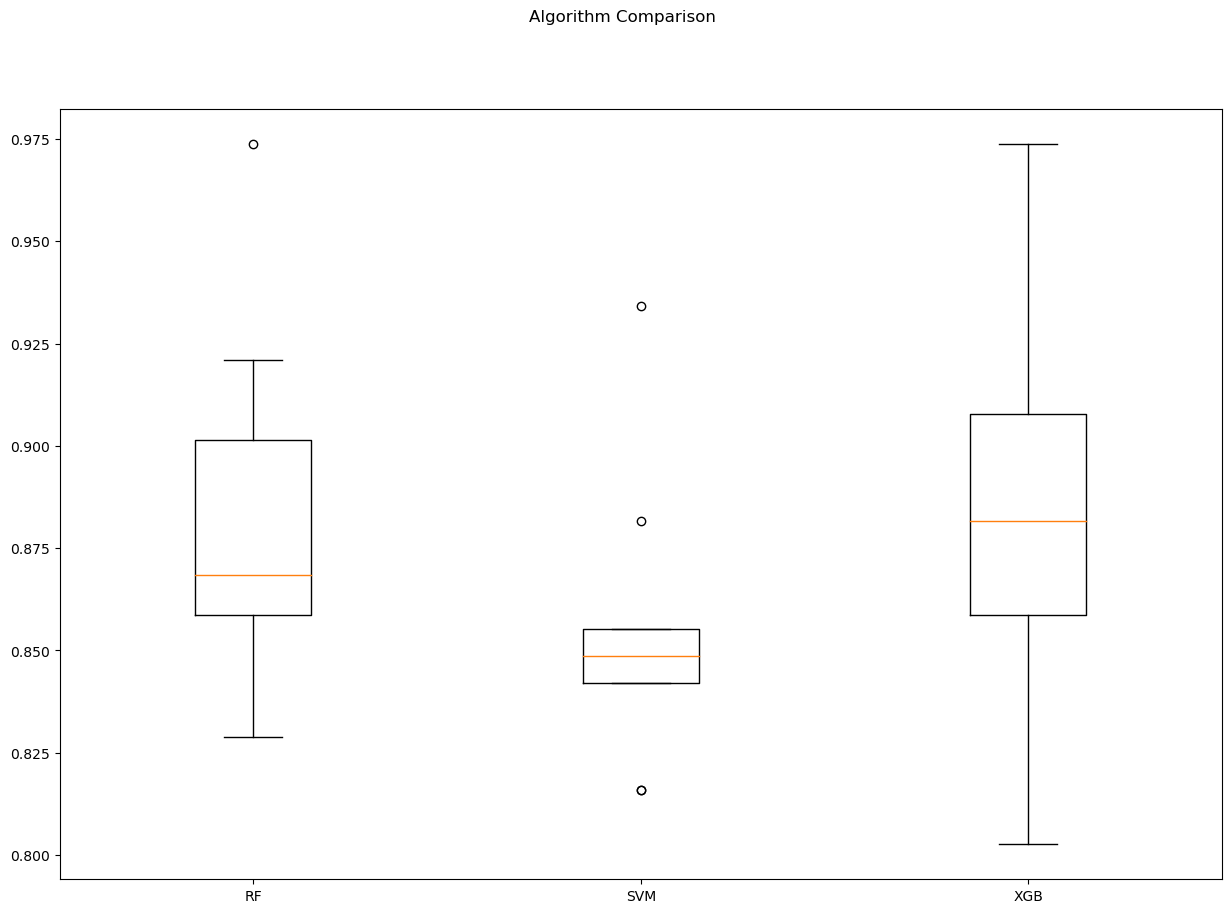

In [49]:
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=12345)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    
    results.append(cv_results)
    names.append(name)
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<h1>6) Model Tuning or Hyperparameter Tuning</h1>

<p>After finding out the cross validation for base models, two standouts are selected and hyperparameter tuning is done. The two best models were selected on the basis of the above cross validation score even though XGB classifier is preferred.</p>

## Random Forest

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 1 - Best Hyperparameters: {'max_depth': 8, 'max_features': 7, 'min_samples_split': 0.1, 'n_estimators': 100}
Iteration 1 - Cross-Validated Score: 0.8657894736842107
Iteration 1 - Accuracy on the test set: 0.8552631578947368
Iteration 1 - Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88       144
           1       0.78      0.85      0.81        84

    accuracy                           0.86       228
   macro avg       0.84      0.85      0.85       228
weighted avg       0.86      0.86      0.86       228

Iteration 1 - Confusion Matrix:
 [[124  20]
 [ 13  71]]


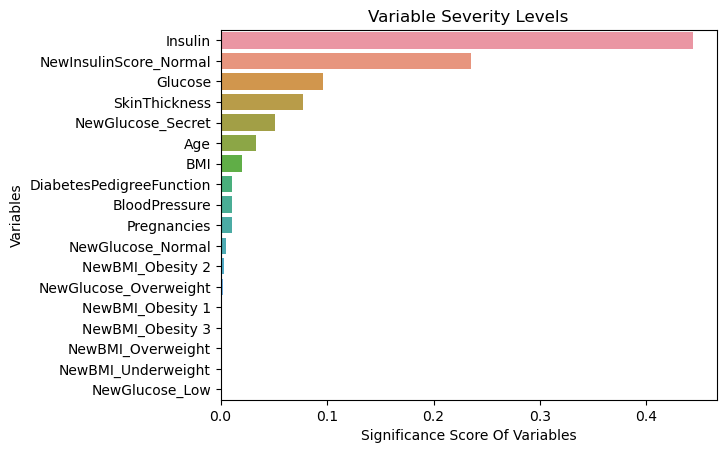

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 2 - Best Hyperparameters: {'max_depth': 3, 'max_features': 7, 'min_samples_split': 0.5, 'n_estimators': 50}
Iteration 2 - Cross-Validated Score: 0.8473684210526315
Iteration 2 - Accuracy on the test set: 0.8464912280701754
Iteration 2 - Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88       144
           1       0.78      0.82      0.80        84

    accuracy                           0.85       228
   macro avg       0.83      0.84      0.84       228
weighted avg       0.85      0.85      0.85       228

Iteration 2 - Confusion Matrix:
 [[124  20]
 [ 15  69]]


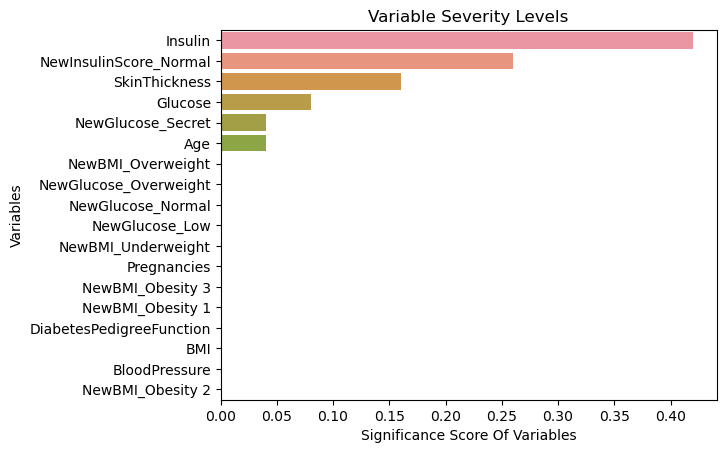

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 3 - Best Hyperparameters: {'max_depth': 8, 'max_features': 7, 'min_samples_split': 0.1, 'n_estimators': 50}
Iteration 3 - Cross-Validated Score: 0.8644736842105264
Iteration 3 - Accuracy on the test set: 0.8596491228070176
Iteration 3 - Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       144
           1       0.80      0.83      0.81        84

    accuracy                           0.86       228
   macro avg       0.85      0.85      0.85       228
weighted avg       0.86      0.86      0.86       228

Iteration 3 - Confusion Matrix:
 [[126  18]
 [ 14  70]]


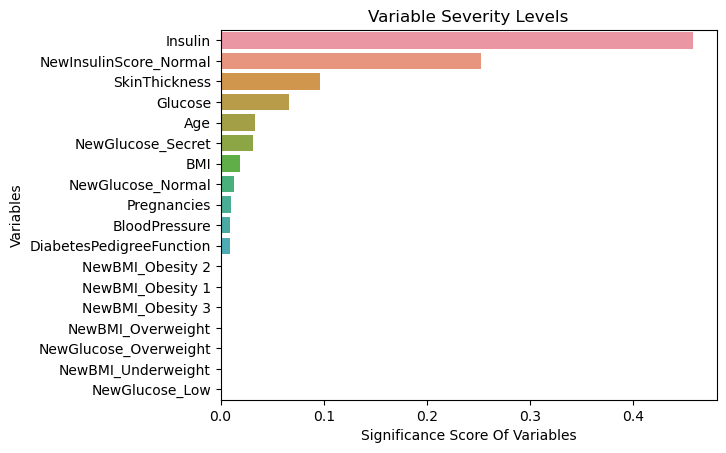

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 4 - Best Hyperparameters: {'max_depth': 5, 'max_features': 5, 'min_samples_split': 0.4, 'n_estimators': 50}
Iteration 4 - Cross-Validated Score: 0.8513157894736842
Iteration 4 - Accuracy on the test set: 0.8464912280701754
Iteration 4 - Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.88       144
           1       0.77      0.83      0.80        84

    accuracy                           0.85       228
   macro avg       0.83      0.84      0.84       228
weighted avg       0.85      0.85      0.85       228

Iteration 4 - Confusion Matrix:
 [[123  21]
 [ 14  70]]


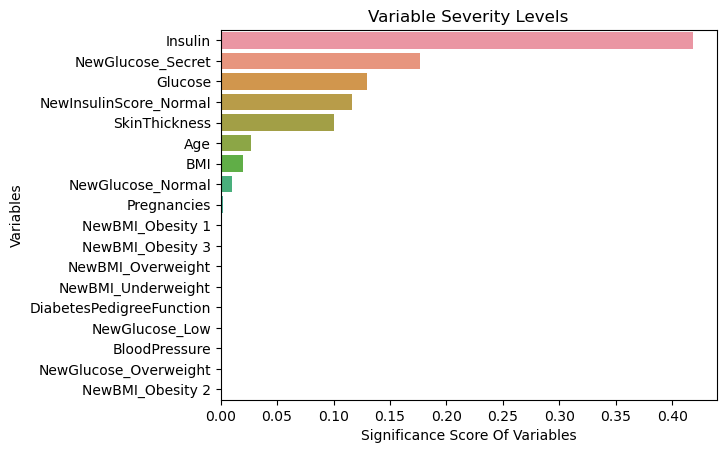

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 5 - Best Hyperparameters: {'max_depth': 3, 'max_features': 3, 'min_samples_split': 0.2, 'n_estimators': 100}
Iteration 5 - Cross-Validated Score: 0.8578947368421053
Iteration 5 - Accuracy on the test set: 0.8552631578947368
Iteration 5 - Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89       144
           1       0.81      0.80      0.80        84

    accuracy                           0.86       228
   macro avg       0.84      0.84      0.84       228
weighted avg       0.85      0.86      0.86       228

Iteration 5 - Confusion Matrix:
 [[128  16]
 [ 17  67]]


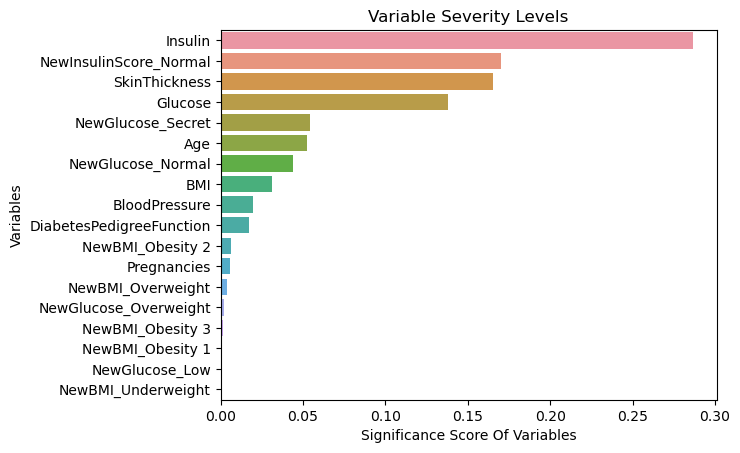

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 6 - Best Hyperparameters: {'max_depth': 8, 'max_features': 7, 'min_samples_split': 0.4, 'n_estimators': 50}
Iteration 6 - Cross-Validated Score: 0.8473684210526317
Iteration 6 - Accuracy on the test set: 0.8508771929824561
Iteration 6 - Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88       144
           1       0.78      0.82      0.80        84

    accuracy                           0.85       228
   macro avg       0.84      0.84      0.84       228
weighted avg       0.85      0.85      0.85       228

Iteration 6 - Confusion Matrix:
 [[125  19]
 [ 15  69]]


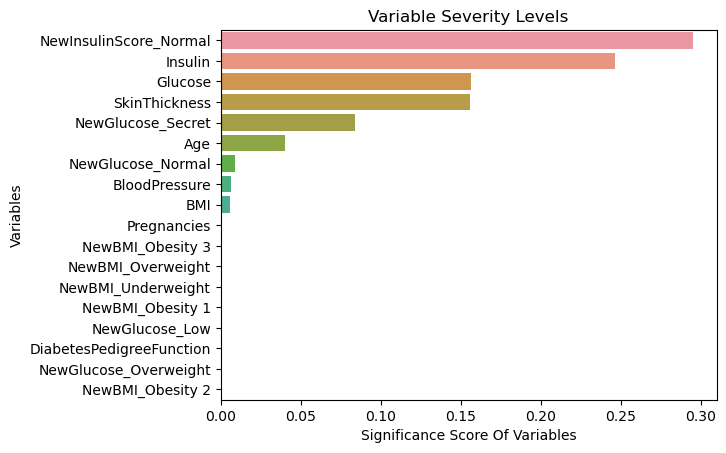

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 7 - Best Hyperparameters: {'max_depth': 8, 'max_features': 7, 'min_samples_split': 0.5, 'n_estimators': 200}
Iteration 7 - Cross-Validated Score: 0.8473684210526315
Iteration 7 - Accuracy on the test set: 0.8377192982456141
Iteration 7 - Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       144
           1       0.77      0.80      0.78        84

    accuracy                           0.84       228
   macro avg       0.82      0.83      0.83       228
weighted avg       0.84      0.84      0.84       228

Iteration 7 - Confusion Matrix:
 [[124  20]
 [ 17  67]]


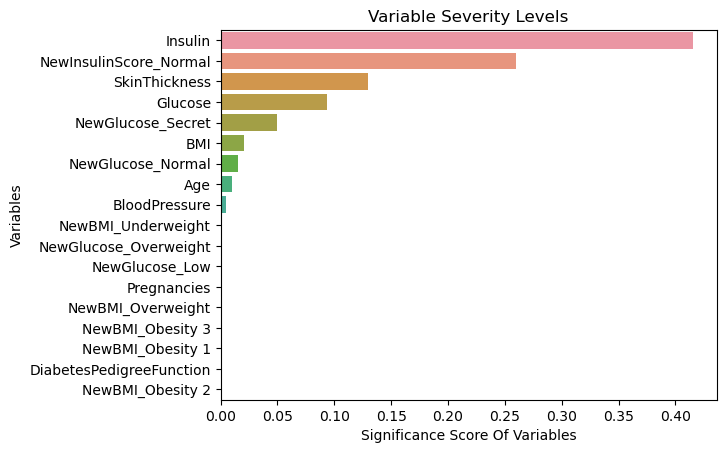

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 8 - Best Hyperparameters: {'max_depth': 5, 'max_features': 7, 'min_samples_split': 0.2, 'n_estimators': 200}
Iteration 8 - Cross-Validated Score: 0.8539473684210526
Iteration 8 - Accuracy on the test set: 0.8508771929824561
Iteration 8 - Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88       144
           1       0.78      0.83      0.80        84

    accuracy                           0.85       228
   macro avg       0.84      0.85      0.84       228
weighted avg       0.85      0.85      0.85       228

Iteration 8 - Confusion Matrix:
 [[124  20]
 [ 14  70]]


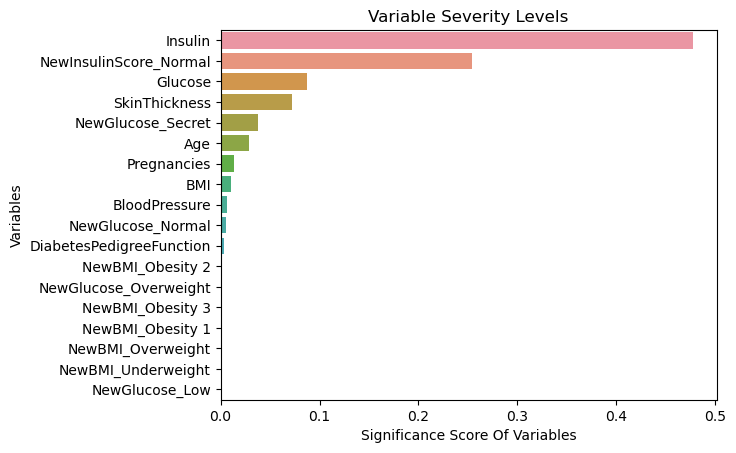

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 9 - Best Hyperparameters: {'max_depth': 8, 'max_features': 3, 'min_samples_split': 0.5, 'n_estimators': 200}
Iteration 9 - Cross-Validated Score: 0.8157894736842104
Iteration 9 - Accuracy on the test set: 0.8026315789473685
Iteration 9 - Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.95      0.86       144
           1       0.87      0.55      0.67        84

    accuracy                           0.80       228
   macro avg       0.83      0.75      0.77       228
weighted avg       0.81      0.80      0.79       228

Iteration 9 - Confusion Matrix:
 [[137   7]
 [ 38  46]]


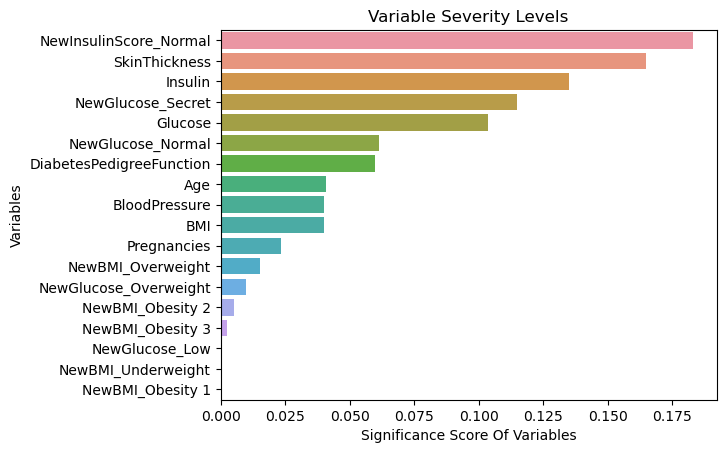

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 10 - Best Hyperparameters: {'max_depth': 3, 'max_features': 3, 'min_samples_split': 0.2, 'n_estimators': 200}
Iteration 10 - Cross-Validated Score: 0.8592105263157894
Iteration 10 - Accuracy on the test set: 0.8508771929824561
Iteration 10 - Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88       144
           1       0.78      0.83      0.80        84

    accuracy                           0.85       228
   macro avg       0.84      0.85      0.84       228
weighted avg       0.85      0.85      0.85       228

Iteration 10 - Confusion Matrix:
 [[124  20]
 [ 14  70]]


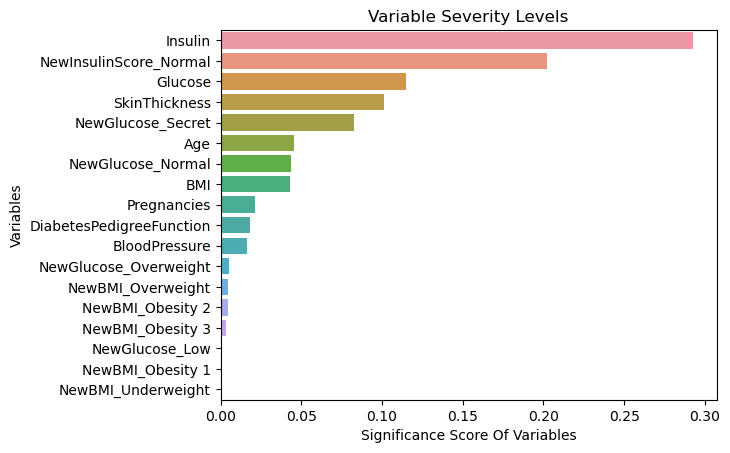

In [50]:
for i in range(10):
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier(random_state=42)
    
    # Define a reduced hyperparameter grid
    rf_params = {
        "n_estimators": [50, 100, 200],
        "max_features": [3, 5, 7],
        "min_samples_split": np.linspace(0.1, 0.5, 5),
        "max_depth": [3, 5, 8]
    }

    # Randomly sample hyperparameter combinations
    random_params = {param: [np.random.choice(values)] for param, values in rf_params.items()}
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(rf, random_params, cv=10, n_jobs=-1, verbose=2)
    rf_result = grid_search.fit(x_train, y_train)
    
    # Best Hyperparameters
    print(f"Iteration {i+1} - Best Hyperparameters:", grid_search.best_params_)
    
    # Train the RandomForest model with the best hyperparameters
    rf_tuned = RandomForestClassifier(**grid_search.best_params_).fit(x_train, y_train)
    
    # Evaluate the model using cross-validation
    cv_score = cross_val_score(rf_tuned, X, y, cv=10).mean()
    print(f"Iteration {i+1} - Cross-Validated Score:", cv_score)
    
    # Make predictions on the test set
    predictions = rf_tuned.predict(x_test)
    
    # Perform any further analysis or evaluation as needed
    accuracy = accuracy_score(y_test, predictions)
    print(f"Iteration {i+1} - Accuracy on the test set:", accuracy)
    print(f"Iteration {i+1} - Classification Report:\n", classification_report(y_test, predictions))
    print(f"Iteration {i+1} - Confusion Matrix:\n", confusion_matrix(y_test, predictions))
    
    # Plot and show feature importances
    feature_imp = pd.Series(rf_tuned.feature_importances_, index=X.columns).sort_values(ascending=False)

    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Significance Score Of Variables')
    plt.ylabel('Variables')
    plt.title("Variable Severity Levels")
    plt.show()


<h2> XGBoost Tuning </h2>

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 1 - Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_split': 0.30000000000000004, 'n_estimators': 100, 'subsample': 0.5}
Iteration 1 - Cross-Validated Score: 0.8828947368421053
Iteration 1 - Accuracy on the test set: 0.868421052631579
Iteration 1 - Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90       144
           1       0.83      0.81      0.82        84

    accuracy                           0.87       228
   macro avg       0.86      0.86      0.86       228
weighted avg       0.87      0.87      0.87       228

Iteration 1 - Confusion Matrix:
 [[130  14]
 [ 16  68]]


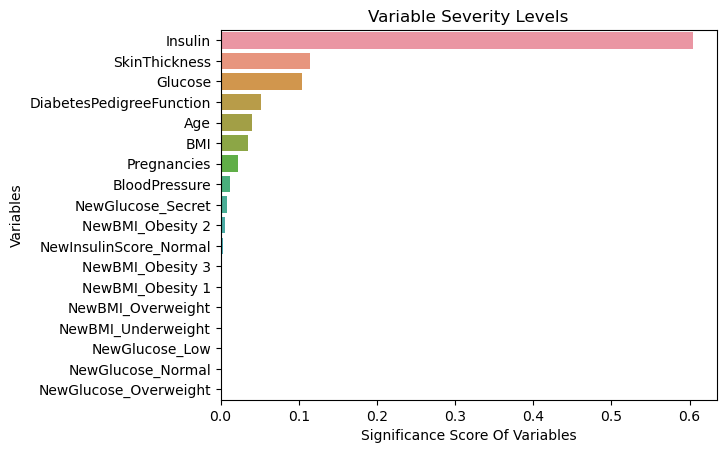

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 2 - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 0.5, 'n_estimators': 200, 'subsample': 0.9}
Iteration 2 - Cross-Validated Score: 0.8894736842105262
Iteration 2 - Accuracy on the test set: 0.8421052631578947
Iteration 2 - Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88       144
           1       0.79      0.77      0.78        84

    accuracy                           0.84       228
   macro avg       0.83      0.83      0.83       228
weighted avg       0.84      0.84      0.84       228

Iteration 2 - Confusion Matrix:
 [[127  17]
 [ 19  65]]


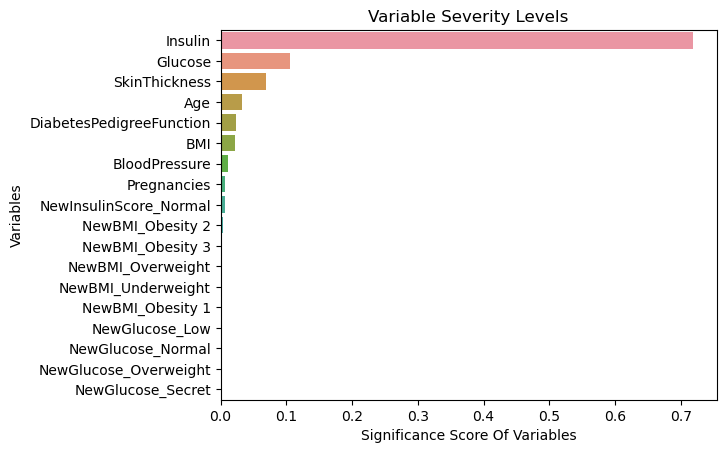

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 3 - Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 0.2, 'n_estimators': 200, 'subsample': 1.0}
Iteration 3 - Cross-Validated Score: 0.8907894736842106
Iteration 3 - Accuracy on the test set: 0.8728070175438597
Iteration 3 - Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       144
           1       0.89      0.75      0.81        84

    accuracy                           0.87       228
   macro avg       0.88      0.85      0.86       228
weighted avg       0.87      0.87      0.87       228

Iteration 3 - Confusion Matrix:
 [[136   8]
 [ 21  63]]


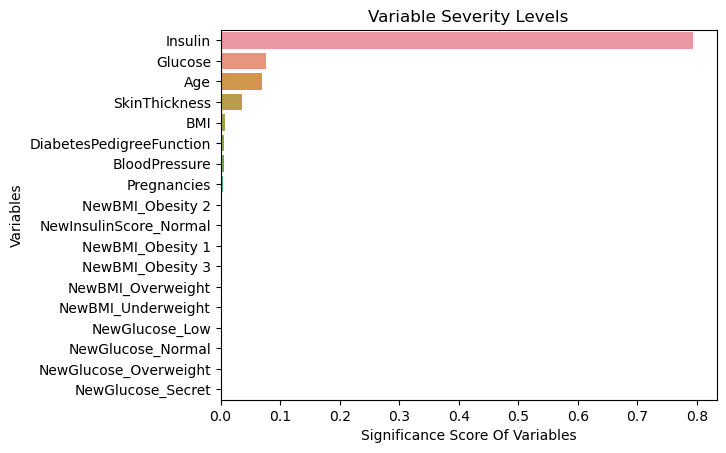

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 4 - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 0.5, 'n_estimators': 200, 'subsample': 1.0}
Iteration 4 - Cross-Validated Score: 0.8894736842105262
Iteration 4 - Accuracy on the test set: 0.8552631578947368
Iteration 4 - Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89       144
           1       0.81      0.80      0.80        84

    accuracy                           0.86       228
   macro avg       0.84      0.84      0.84       228
weighted avg       0.85      0.86      0.86       228

Iteration 4 - Confusion Matrix:
 [[128  16]
 [ 17  67]]


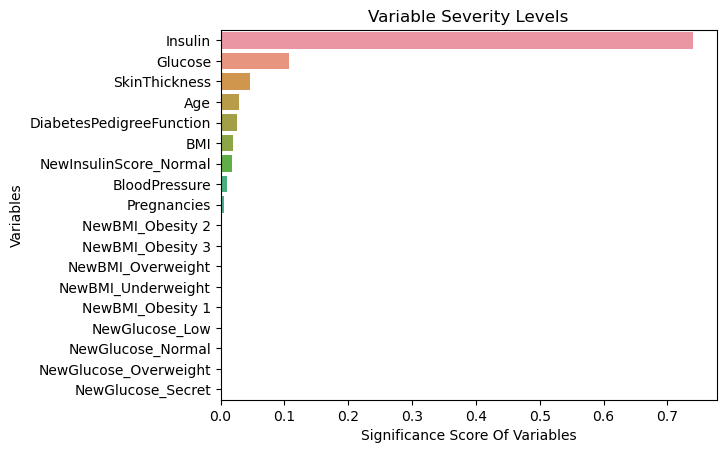

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 5 - Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 0.30000000000000004, 'n_estimators': 50, 'subsample': 1.0}
Iteration 5 - Cross-Validated Score: 0.8131578947368421
Iteration 5 - Accuracy on the test set: 0.8157894736842105
Iteration 5 - Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.99      0.87       144
           1       0.96      0.52      0.68        84

    accuracy                           0.82       228
   macro avg       0.87      0.75      0.77       228
weighted avg       0.85      0.82      0.80       228

Iteration 5 - Confusion Matrix:
 [[142   2]
 [ 40  44]]


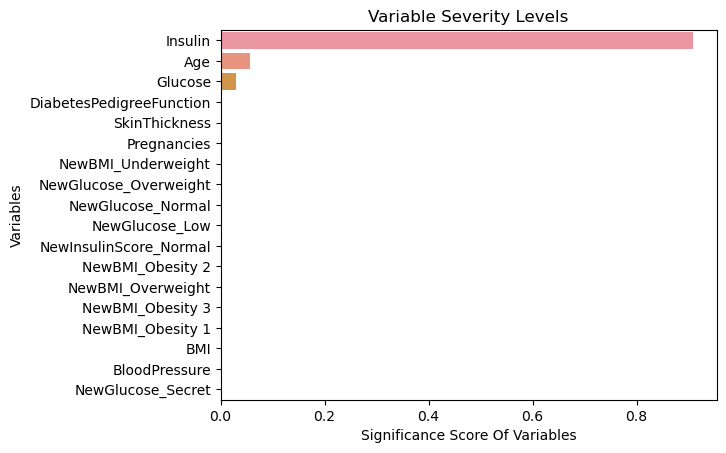

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 6 - Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 0.30000000000000004, 'n_estimators': 50, 'subsample': 0.5}
Iteration 6 - Cross-Validated Score: 0.8763157894736843
Iteration 6 - Accuracy on the test set: 0.8640350877192983
Iteration 6 - Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89       144
           1       0.84      0.79      0.81        84

    accuracy                           0.86       228
   macro avg       0.86      0.85      0.85       228
weighted avg       0.86      0.86      0.86       228

Iteration 6 - Confusion Matrix:
 [[131  13]
 [ 18  66]]


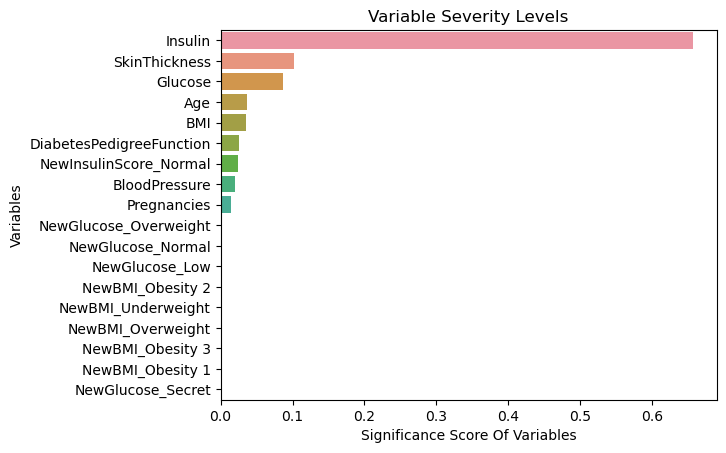

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 7 - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 0.4, 'n_estimators': 200, 'subsample': 1.0}
Iteration 7 - Cross-Validated Score: 0.8789473684210526
Iteration 7 - Accuracy on the test set: 0.8464912280701754
Iteration 7 - Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       144
           1       0.80      0.79      0.79        84

    accuracy                           0.85       228
   macro avg       0.84      0.83      0.83       228
weighted avg       0.85      0.85      0.85       228

Iteration 7 - Confusion Matrix:
 [[127  17]
 [ 18  66]]


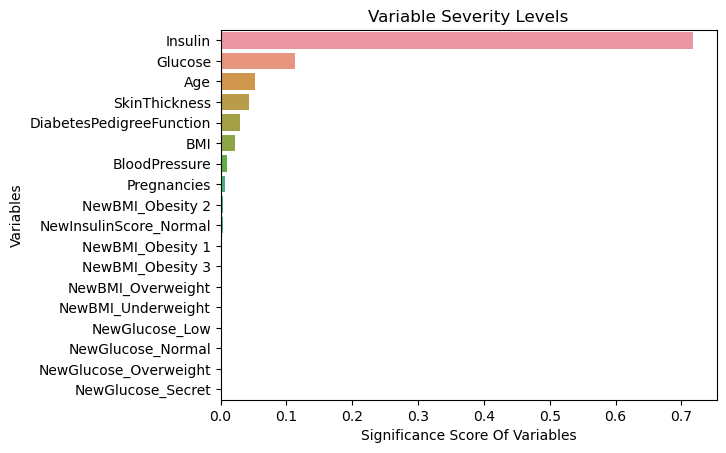

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 8 - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 8, 'min_samples_split': 0.1, 'n_estimators': 200, 'subsample': 1.0}
Iteration 8 - Cross-Validated Score: 0.8907894736842105
Iteration 8 - Accuracy on the test set: 0.881578947368421
Iteration 8 - Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91       144
           1       0.86      0.81      0.83        84

    accuracy                           0.88       228
   macro avg       0.88      0.87      0.87       228
weighted avg       0.88      0.88      0.88       228

Iteration 8 - Confusion Matrix:
 [[133  11]
 [ 16  68]]


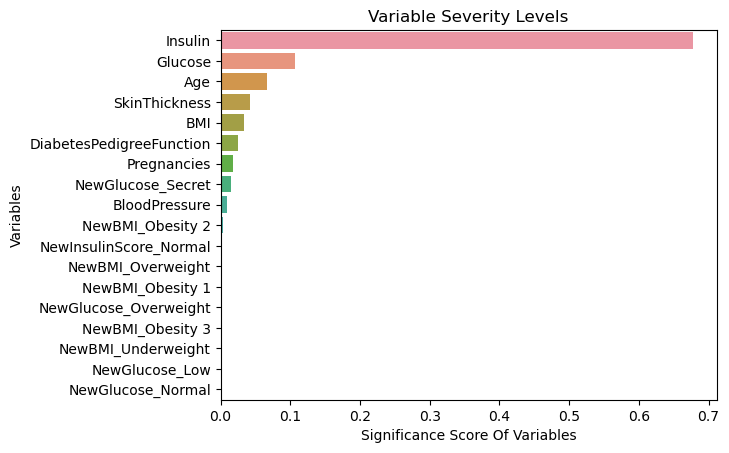

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 9 - Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_split': 0.2, 'n_estimators': 100, 'subsample': 0.5}
Iteration 9 - Cross-Validated Score: 0.8736842105263157
Iteration 9 - Accuracy on the test set: 0.8596491228070176
Iteration 9 - Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       144
           1       0.82      0.80      0.81        84

    accuracy                           0.86       228
   macro avg       0.85      0.85      0.85       228
weighted avg       0.86      0.86      0.86       228

Iteration 9 - Confusion Matrix:
 [[129  15]
 [ 17  67]]


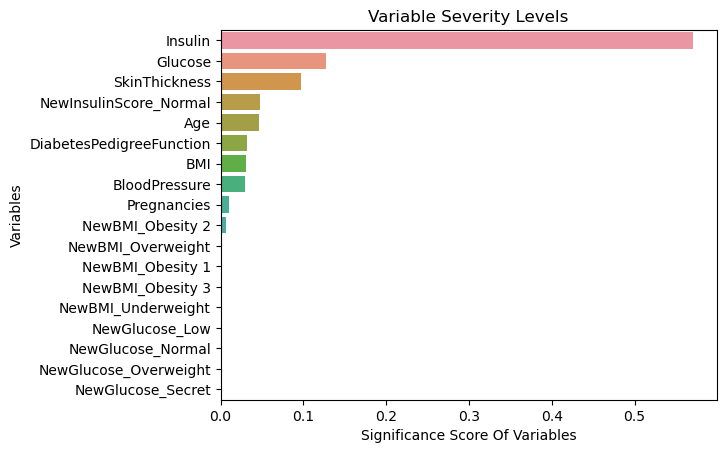

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Iteration 10 - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 0.1, 'n_estimators': 100, 'subsample': 0.9}
Iteration 10 - Cross-Validated Score: 0.8828947368421052
Iteration 10 - Accuracy on the test set: 0.8859649122807017
Iteration 10 - Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       144
           1       0.87      0.81      0.84        84

    accuracy                           0.89       228
   macro avg       0.88      0.87      0.88       228
weighted avg       0.89      0.89      0.89       228

Iteration 10 - Confusion Matrix:
 [[134  10]
 [ 16  68]]


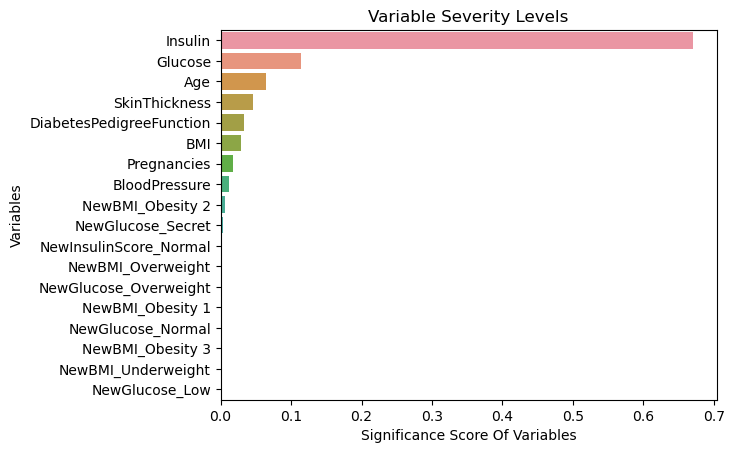

In [51]:
for i in range(10):
    # Initialize the GradientBoostingClassifier
    xgb = GradientBoostingClassifier(random_state=42)
    
    # Define a reduced hyperparameter grid
    xgb_params = {
        "learning_rate": [0.01, 0.1, 0.2],
        "min_samples_split": np.linspace(0.1, 0.5, 5),
        "max_depth": [3, 5, 8],
        "subsample": [0.5, 0.9, 1.0],
        "n_estimators": [50, 100, 200]
    }

    # Randomly sample hyperparameter combinations
    random_params = {param: [np.random.choice(values)] for param, values in xgb_params.items()}
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(xgb, random_params, cv=10, n_jobs=-1, verbose=2)
    xgb_result = grid_search.fit(x_train, y_train)
    
    # Best Hyperparameters
    print(f"Iteration {i+1} - Best Hyperparameters:", grid_search.best_params_)
    
    # Train the XGBoost model with the best hyperparameters
    xgb_tuned = GradientBoostingClassifier(**grid_search.best_params_).fit(x_train, y_train)
    
    # Evaluate the model using cross-validation
    cv_score = cross_val_score(xgb_tuned, X, y, cv=10).mean()
    print(f"Iteration {i+1} - Cross-Validated Score:", cv_score)
    
    # Make predictions on the test set
    predictions = xgb_tuned.predict(x_test)
    
    # Perform any further analysis or evaluation as needed
    accuracy = accuracy_score(y_test, predictions)
    print(f"Iteration {i+1} - Accuracy on the test set:", accuracy)
    print(f"Iteration {i+1} - Classification Report:\n", classification_report(y_test, predictions))
    print(f"Iteration {i+1} - Confusion Matrix:\n", confusion_matrix(y_test, predictions))
    
    # Plot and show feature importances
    feature_imp = pd.Series(xgb_tuned.feature_importances_, index=X.columns).sort_values(ascending=False)

    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Significance Score Of Variables')
    plt.ylabel('Variables')
    plt.title("Variable Severity Levels")
    plt.show()


<p>Comparing with the cross validation scores, XGB classifier stand out to be the clear winner. Hence, prediction is done via XGB</p>

<h1> 7) Prediction </h1>

<p>Till now, after working on EDA, Feature Engineering, Validation of Models, and Hyperparameter Tuning and find the best working Model for my dataset. Next, I did prediction from my test dataset and storing the result in CSV</p>

In [52]:
new_predictions = xgb_tuned.predict([[3.0,193.0,70.0,31.0,169.50,34.9,0.241,25.0,1,0,0,0,0,0,0,0,0,1]])

In [53]:
# Assuming new_predictions is a NumPy array or Pandas Series containing predicted labels

for index, prediction in enumerate(new_predictions):
    if prediction == 0:
        print(f"Sample {index + 1}: No diabetes")
    elif prediction == 1:
        print(f"Sample {index + 1}: Diabetes")
    else:
        print(f"Sample {index + 1}: Invalid prediction value")


Sample 1: Diabetes


In [54]:
x_test.to_csv('new_diabetes.csv', index=False)

In [55]:
x_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
400,4.0,95.0,64.0,32.0,169.5,32.0,0.161,31.0,1,0,0,0,0,0,0,1,0,0
329,6.0,105.0,70.0,32.0,68.0,30.8,0.122,37.0,1,0,0,0,0,1,0,0,1,0
98,6.0,93.0,50.0,27.0,64.0,28.7,0.356,23.0,0,0,0,1,0,1,0,1,0,0
504,3.0,96.0,78.0,39.0,100.0,37.3,0.238,40.0,0,1,0,0,0,1,0,1,0,0
111,8.0,155.0,62.0,26.0,495.0,34.0,0.543,46.0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,1.0,119.0,44.0,47.0,63.0,35.5,0.280,25.0,0,1,0,0,0,1,0,0,1,0
19,1.0,115.0,70.0,30.0,96.0,34.6,0.529,32.0,1,0,0,0,0,1,0,0,1,0
760,2.0,88.0,58.0,26.0,16.0,28.4,0.766,22.0,0,0,0,1,0,1,0,1,0,0
143,10.0,108.0,66.0,32.0,169.5,32.4,0.272,42.0,1,0,0,0,0,0,0,0,1,0


<h1>8) Saving best model </h1>

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
# Creating a GradientBoostingClassifier instance
best_model = GradientBoostingClassifier()

# Training (fitting) the model on the training data
best_model.fit(X_train, y_train)


GradientBoostingClassifier()

In [57]:
print("Number of features in training data:", X_train.shape[1])

Number of features in training data: 18


In [58]:
import os
current_directory = os.getcwd()
file_name = 'diabetes_model.pkl'
file_path = os.path.join(current_directory,file_name)
joblib.dump(best_model, file_path)
print(f"Best model saved. File path: {file_path}")

Best model saved. File path: C:\Users\97798\Documents\AI (Coursework)\21049549 Niwesh Dhital\21049549 Niwesh Dhital (Code and Dataset)\diabetes_model.pkl
